In [1]:
# import data
import numpy as np
import json

# Change .json filename to select animal ID number
IDnumber = 3402
loadstring = "data/pyData/{}/{}_Data_S_Notch14_1.json"

# import standard experiment data (XS) and metadata (S_labels)
with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XS = pxx.reshape(a*b, c).T
S_labels = data[1]


loadstring = "data/pyData/{}/{}_Data_L_Notch14_1.json"

# import lidocaine experiment data (XL) and metadata (L_labels)
with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XL = pxx.reshape(a*b, c).T
L_labels = data[1]


loadstring = "data/pyData/{}/{}_Data_C_Notch14_1.json"

# import cholinergic blocker experiment data (XC) and metadata (C_labels)
with open(loadstring.format(IDnumber, IDnumber)) as f:
    data = json.load(f)
pxx = np.array(data[0])
pxx = np.log(pxx)
a, b, c = pxx.shape
XC = pxx.reshape(a*b, c).T
C_labels = data[1]

# Train data ONLY on standard experiments from day 1: X, S_labels where subject contains 1
# stimON = 1 vs nonstim = 0 (baseline AND stimOFF)

days = np.zeros(len(S_labels['allWindows']['subject']))
for k in range(0, len(S_labels['allWindows']['subject'])):
    days[k] = int(S_labels['allWindows']['subject'][k][6])-1
Ldays = np.zeros(len(L_labels['allWindows']['subject']))
for k in range(0, len(L_labels['allWindows']['subject'])):
    Ldays[k] = int(L_labels['allWindows']['subject'][k][6])-1
Cdays = np.zeros(len(C_labels['allWindows']['subject']))
for k in range(0, len(L_labels['allWindows']['subject'])):
    Cdays[k] = int(C_labels['allWindows']['subject'][k][6])-1
    
numDay = int(np.ceil(max(days)))+1
duration = 539
numLDay = int(np.ceil(max(Ldays)))+1
Lduration = 359
numCDay = int(np.ceil(max(Ldays)))+1
Cduration = 359
    
X_arr = np.zeros((numDay, duration), dtype = int)
Y_arr = np.zeros((numDay, duration), dtype = int)
LSNS_arr = np.zeros((numLDay, Lduration), dtype = int)
Lctrl_arr = np.zeros((numLDay, Lduration), dtype = int)
Hex_arr = np.zeros((numCDay, Cduration), dtype = int)
Atr_arr = np.zeros((numCDay, Cduration), dtype = int)

for k in range(0, len(S_labels['allWindows']['subject'])):
    d = int(S_labels['allWindows']['subject'][k][6])-1
    w = S_labels['allWindows']['windowID'][k]-1
    if w < duration: 
        X_arr[d, w] = k
        Y_arr[d, w] = S_labels['allWindows']['stimOn'][k]

for k in range(0, len(L_labels['allWindows']['subject'])):
    s = int(L_labels['allWindows']['subject'][k][6])
    d = int(L_labels['allWindows']['subject'][k][6])-1
    w = L_labels['allWindows']['windowID'][k]-1
    if L_labels['allWindows']['subject'][k][5] == 'S':
        if w < Lduration: 
            LSNS_arr[d, w] = k
    elif L_labels['allWindows']['subject'][k][5] == 'm':
        if w < Lduration: 
            Lctrl_arr[d, w] = k
            
for k in range(0, len(C_labels['allWindows']['subject'])):
    c = int(C_labels['allWindows']['subject'][k][6])
    d = int(C_labels['allWindows']['subject'][k][6])-1
    w = C_labels['allWindows']['windowID'][k]-1
    if C_labels['allWindows']['subject'][k][5] == 'e':
        if w < Lduration: 
            Atr_arr[d, w] = k
    elif C_labels['allWindows']['subject'][k][5] == 'm':
        if w < Lduration: 
            Hex_arr[d, w] = k

X_list = X_arr.reshape(numDay*duration, 1)
Y_list = Y_arr.reshape(numDay*duration, 1)
LSNS_list = LSNS_arr.reshape(numLDay*Lduration, 1)
Lctrl_list = Lctrl_arr.reshape(numLDay*Lduration, 1)
Atr_list = Atr_arr.reshape(numCDay*Cduration, 1)
Hex_list = Hex_arr.reshape(numCDay*Cduration, 1)

X_all = XS
Y_all = np.array(S_labels['allWindows']['stimOn'])
L_all = XL
C_all = XC

In [2]:
string0 = "data/pyData/{}/{}_7x1x1Components.txt"
components = np.loadtxt(string0.format(IDnumber, IDnumber), delimiter = '\t')

rocString = "data/pyData/{}/{}_nestedROC_AUC.txt"
roc_auc = np.loadtxt(rocString.format(IDnumber, IDnumber), delimiter = '\t')
roc_auc = roc_auc.reshape(numDay, (numDay-1), roc_auc.shape[1])

C = int(components[np.argsort(np.mean(np.mean(roc_auc, axis = 0), axis = 0))[-1]])

In [3]:
#if IDnumber  == 3402:
#    trainDays = range(0, 5)
#    testDays = range(5, 6)
#elif IDnumber == 2705:
#    trainDays = range(0, 8)
#    testDays = range(8, 9)
    
trainDays = range(0, numDay)
testDays = range(0, numDay)
    
X_train_set = X_all[X_arr[trainDays, :]].reshape(len(trainDays)*duration, 600)
Y_train = Y_arr[trainDays, :].reshape(len(trainDays)*duration)

X_test_set = X_all[X_arr[testDays, :]].reshape(len(testDays)*duration, 600)
Y_test = Y_arr[testDays, :].reshape(len(testDays)*duration)

ROC AUC: 69.49%


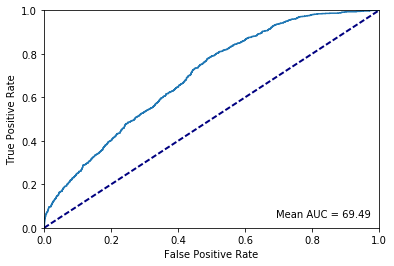

In [4]:
from sklearn.decomposition import FastICA
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_curve, auc

ica = FastICA(n_components = C, max_iter = 5000,tol = 0.0001) #tol = 0.001
X_train = ica.fit_transform(X_train_set) #pull components from ica fit transformation
X_test = ica.transform(X_test_set)

clf = svm.SVC(kernel = 'linear', class_weight = 'balanced', probability = True)
y_score = clf.fit(X_train, Y_train).decision_function(X_test)
fpr, tpr, _ = roc_curve(Y_test, y_score)
roc_auc = auc(fpr, tpr)

s = "ROC AUC: {0:.2f}%"
print(s.format(roc_auc*100))

import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.text(0.975, 0.05, 'Mean AUC = %0.2f' % (roc_auc*100), horizontalalignment = 'right')
plt.show()

from sklearn.externals import joblib
string6 = string4 = "data/pyData/{}/{}_lumpedCLF.pkl"
joblib.dump(clf, string6.format(IDnumber, IDnumber))
string7 = string4 = "data/pyData/{}/{}_lumpedICA.pkl"
joblib.dump(ica, string7.format(IDnumber, IDnumber))

In [5]:
LSNS_test_set = L_all[LSNS_list].reshape(LSNS_list.shape[0], 600)
LSNS_test = ica.transform(LSNS_test_set)
LSNS_score = clf.predict_proba(LSNS_test)

Lctrl_test_set = L_all[Lctrl_list].reshape(Lctrl_list.shape[0], 600)
Lctrl_test = ica.transform(Lctrl_test_set)
Lctrl_score = clf.predict_proba(Lctrl_test) #decision_function

Atr_test_set = C_all[Atr_list].reshape(Atr_list.shape[0], 600)
Atr_test = ica.transform(Atr_test_set)
Atr_score = clf.predict_proba(Atr_test)

Hex_test_set = C_all[Hex_list].reshape(Hex_list.shape[0], 600)
Hex_test = ica.transform(Hex_test_set)
Hex_score = clf.predict_proba(Hex_test)

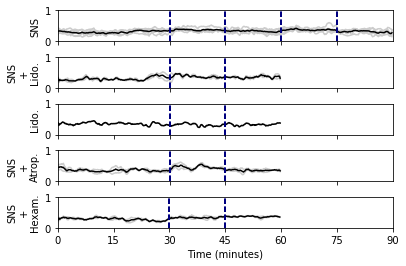

In [6]:
y_score = clf.predict_proba(X_test)

y_prob = y_score[:, 1].reshape(len(testDays), duration)
LSNS_prob = LSNS_score[:, 1].reshape(numLDay, Lduration)
Lctrl_prob = Lctrl_score[:, 1].reshape(numLDay, Lduration)
Atr_prob = Atr_score[:, 1].reshape(numCDay, Cduration)
Hex_prob = Hex_score[:, 1].reshape(numCDay, Cduration)

N = 5

wS = np.arange(0, duration-N+1) + (N-2)
wL = np.arange(0, Lduration-N+1) + (N-2)
wC = np.arange(0, Cduration-N+1) + (N-2)

all_prob = [y_prob, LSNS_prob, Lctrl_prob, Atr_prob, Hex_prob]
widths = [wS, wL, wL, wC, wC]

if IDnumber == 3402: grp = [range(len(testDays)), range(numLDay), range(1), range(numCDay), range(numCDay)]
elif IDnumber == 2705: grp = [range(len(testDays)), range(numLDay), range(numLDay), range(numCDay), range(numCDay)]
mean = [np.zeros((duration)), np.zeros((Lduration)), np.zeros((Lduration)), np.zeros((Cduration)), np.zeros((Cduration))]

for k in range(0, 5):
    for d in grp[k]:
        cumsum, moving_aves = [0], []
        for i, x in enumerate(all_prob[k][d, ], 1):
            cumsum.append(cumsum[i-1] + x)
            if i >= N:
                moving_ave = (cumsum[i] - cumsum[i-N])/N
                moving_aves.append(moving_ave)
        all_prob[k][d, widths[k]] = moving_aves
    mean[k]=np.mean(all_prob[k][grp[k], ], axis=0)

fig, ax = plt.subplots(5, 1, sharex = True, sharey = True)
lbl = ['SNS', 'SNS\n+\nLido.', 'Lido.', 'SNS\n+\nAtrop.', 'SNS\n+\nHexam.']

for k in range(0, 5):
    for d in grp[k]:
        ax[k].plot(range(0, all_prob[k].shape[1]), all_prob[k][d, :], c = '0.8')
    ax[k].plot(range(0, mean[k].shape[0]), mean[k], 'k')
    ax[k].plot([180, 180], [0, 1], color='navy', lw=2, linestyle='--')
    ax[k].plot([270, 270], [0, 1], color='navy', lw=2, linestyle='--')
    if k == 0:
        ax[k].plot([360, 360], [0, 1], color='navy', lw=2, linestyle='--')
        ax[k].plot([450, 450], [0, 1], color='navy', lw=2, linestyle='--')  
    
    ax[k].set_xlim(0, duration)
    ax[k].set_xticks(np.arange(0, duration+90, 90))
    ax[k].set_xticklabels(np.arange(0, (duration+90)/6, 15, dtype = int))
    ax[k].set_ylabel(lbl[k])

fig.subplots_adjust(hspace=.5)
plt.ylim([0, 1])
plt.xlabel("Time (minutes)")
    
plt.show()

s = "data/pyData/GraphOutput/{}_Trials"
fig.savefig(s.format(IDnumber))

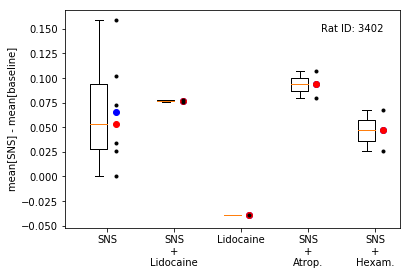

In [7]:
s1 = plt.figure()
baseline = np.arange(0, 180)
SNS = np.arange(180, 270)
response = [0] * 5
for k in range(0, 5):
    response[k] = [0] * len(grp[k])
    for d in grp[k]:
        response[k][d] = np.mean(all_prob[k][d, SNS]) - np.mean(all_prob[k][d, baseline])

    plt.scatter([k+1.25], np.mean(response[k]), c = 'b', marker = 'o')
    plt.scatter([k+1.25], np.median(response[k]), c = 'r', marker = 'o')
    plt.scatter([k+1.25]*len(grp[k]), response[k], c = 'k', marker = '.')
    
responseArr = np.empty((5, numDay))
responseArr[:] = np.nan
for k in range(0, 5):
    responseArr[k, grp[k]] = response[k]
    
s = "data/pyData/{}/{}_Response"
np.savetxt(s.format(IDnumber,IDnumber), responseArr)
    
ax = plt.axes()
Y = ax.get_ylim()
if Y[0] > 0: 
    ax.set_ylim([0, Y[1]])
    Y = ax.get_ylim()

s = "Rat ID: {}"
    
plt.boxplot(response, widths = 0.25)
plt.xticks(np.arange(1, 6)+0.125, ['SNS', 'SNS\n+\nLidocaine', 'Lidocaine', 'SNS\n+\nAtrop.', 'SNS\n+\nHexam.'])
plt.text(5.25, Y[1]-0.1*(Y[1]-Y[0]), s.format(IDnumber), horizontalalignment = 'right')
plt.ylabel("mean[SNS] - mean[baseline]")
plt.show()

s = "data/pyData/GraphOutput/{}_Response"
s1.savefig(s.format(IDnumber))

In [8]:
import scipy.stats as stats
_, p = stats.f_oneway(response[0], response[1], response[2], response[3], response[4])

s = "ANOVA p-value = {0:.4f}"
print(s.format(p))

if p < 0.05:

    data = []
    labels = []

    for k in range(0, 5):
        for d in grp[k]:
            data.append(response[k][d])
            labels.append(k)

    from statsmodels.sandbox.stats.multicomp import MultiComparison
    mc = MultiComparison(data, labels)
    print(mc.tukeyhsd())

ANOVA p-value = 0.3023
